In [1]:
# !pip install pytest==5.4.0
# !pip install pytest

## Defining Noisy Environment ##

In [2]:
from tqdm import tqdm
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')

In [3]:
from sklearn.model_selection import train_test_split
mndata = MNIST('data')
x_train_data, y_train_data = mndata.load_training()
x_test_data, y_test_data = mndata.load_testing()

training_steps=50000
checkpoint_loss=1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

class NoisyMnistEnv:
    def __init__(self, split, input_number_min, input_number_max, batch_size=32, seed=0):
        self.seed = seed
        self.split = split
        if self.split == "train":
            self.x, self.y = x_train_data, y_train_data
        elif self.split == "test":
            self.x, self.y = x_test_data, y_test_data
        self.batch_size = batch_size
        self.input_number_min = input_number_min
        self.input_number_max = input_number_max
        
    
    def step(self):
        x_arr = np.zeros((self.batch_size, 28 * 28))
        y_arr = np.zeros((self.batch_size, 28 * 28))

        for i in range(self.batch_size):
            input_number = np.random.randint(self.input_number_min, self.input_number_max)
            if input_number == 0:
                output_number = 0
            if input_number == 1:
                output_number = np.random.randint(2, 10)
            input_data = self.get_random_sample_of_number(input_number)
            if input_number == 1:
                output_data = self.get_random_sample_of_number(output_number)
            elif input_number == 0:
                output_data = input_data
            x_arr[i] = np.array(input_data)
            y_arr[i] = np.array(output_data)
        return x_arr, y_arr
    
    def get_random_sample_of_number(self, number):
        random_num = np.random.randint(0, len(self.y) - 1)
        if self.y[random_num] == number:
            return self.x[random_num]
        else:
            return self.get_random_sample_of_number(number)

device: cuda


# Environment Tests

In [5]:
__file__ = 'noisy_mnist_aleatoric_uncertainty-for-poster.ipynb'
import ipytest.magics
import pytest

ipytest.autoconfig()

ModuleNotFoundError: No module named 'ipytest'

# Qualitative checks that environment is behaving the way it should be 

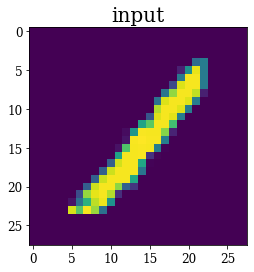

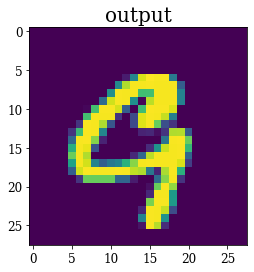

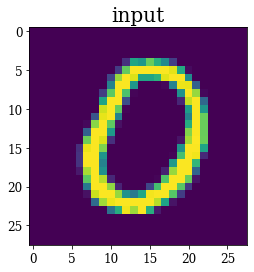

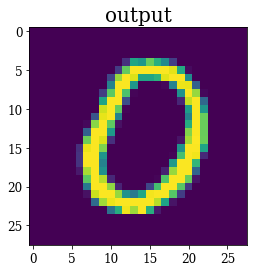

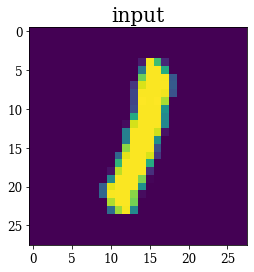

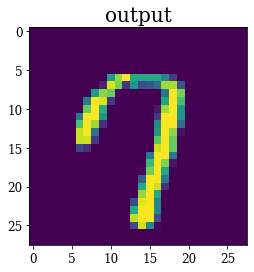

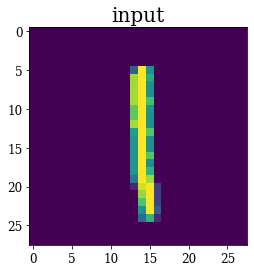

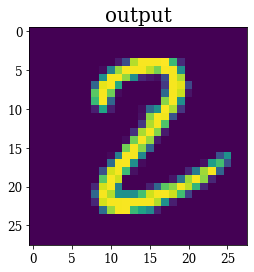

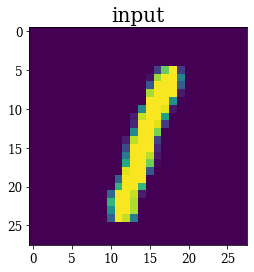

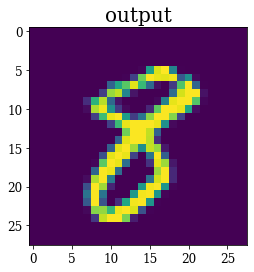

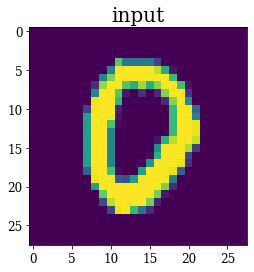

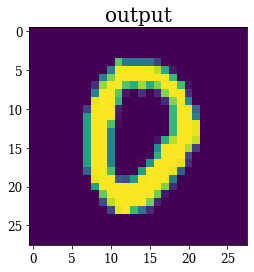

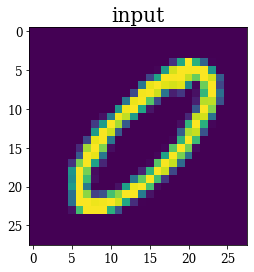

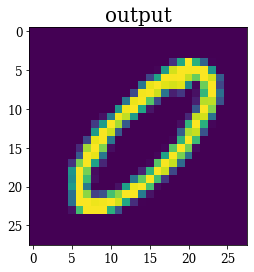

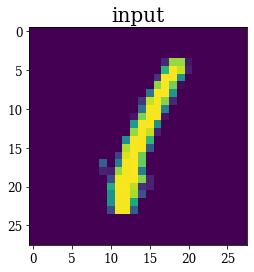

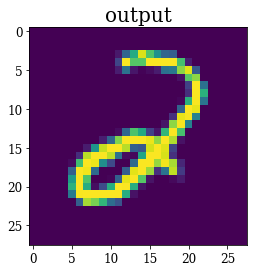

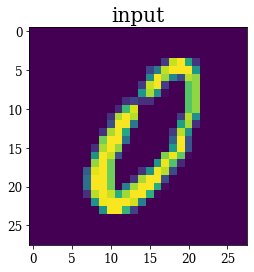

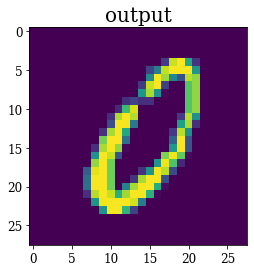

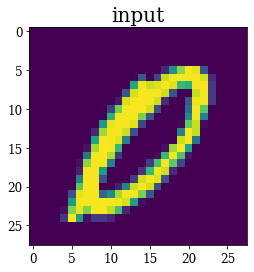

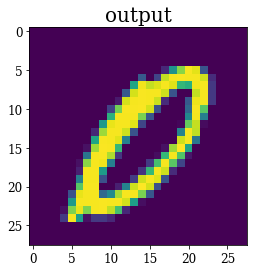

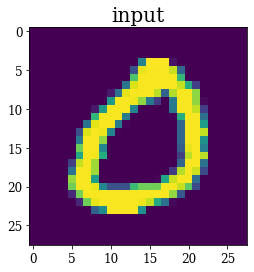

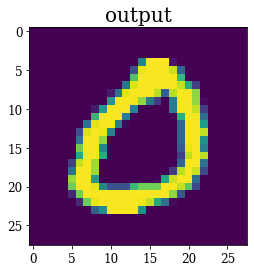

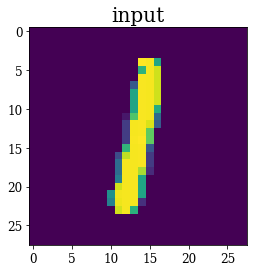

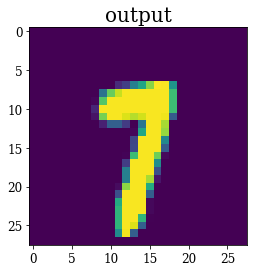

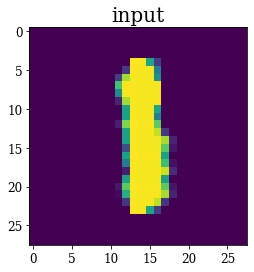

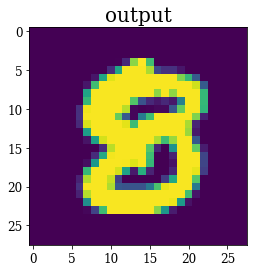

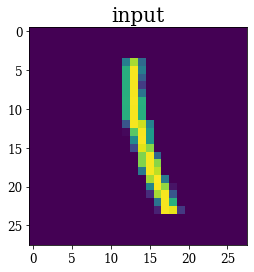

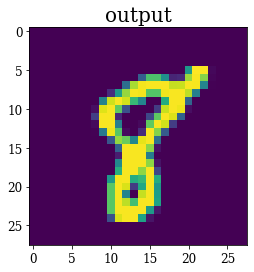

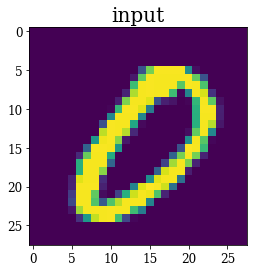

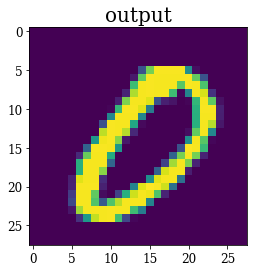

In [3]:
mnist_env = NoisyMnistEnv("test", 0, 2)
x, y  = mnist_env.step()
count = 0
for i in zip(x,y):
    count += 1
    if count == 16:
        break
    plt.title("input", fontsize=20)
    plt.imshow(np.squeeze(i[0]).reshape(28, 28))
    plt.show()
    plt.title("output", fontsize=20)
    plt.imshow(np.squeeze(i[1]).reshape(28, 28))
    plt.show()

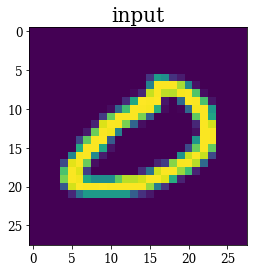

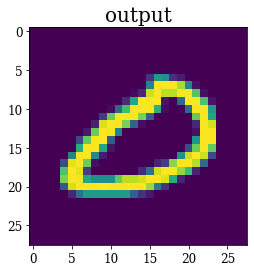

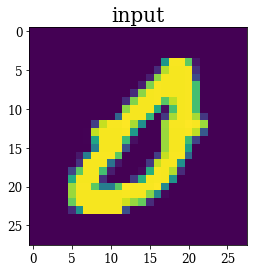

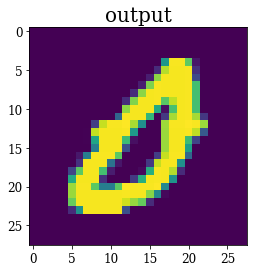

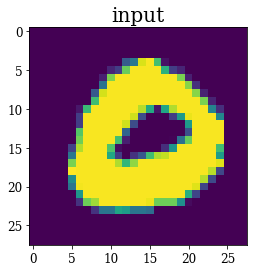

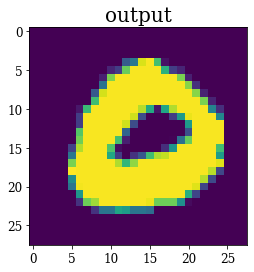

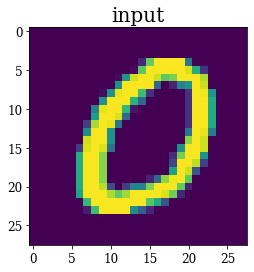

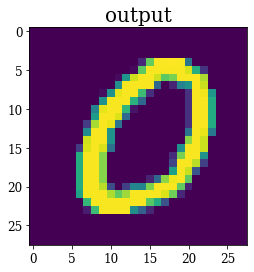

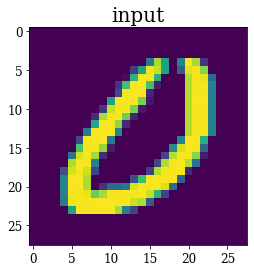

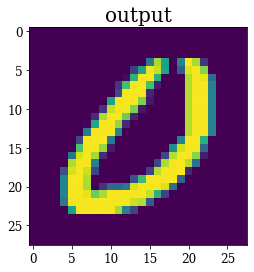

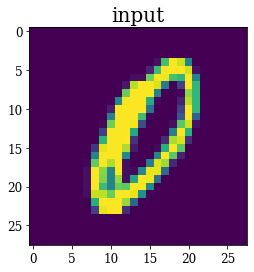

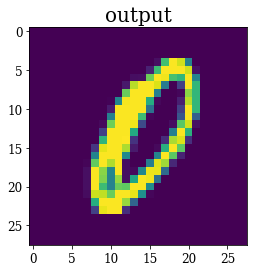

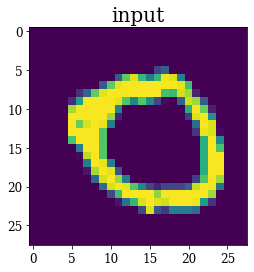

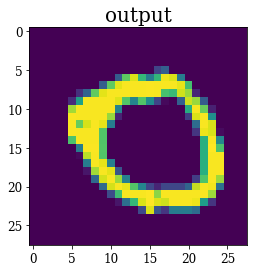

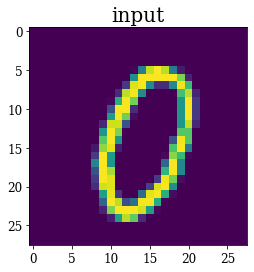

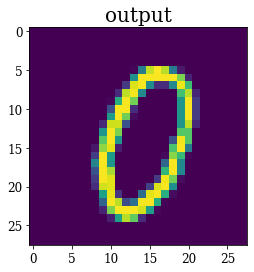

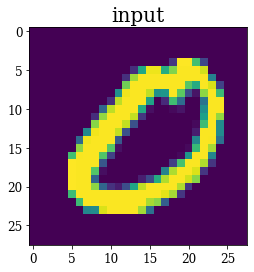

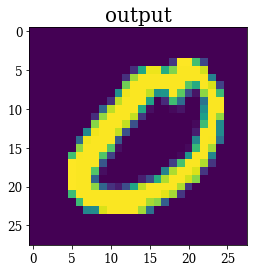

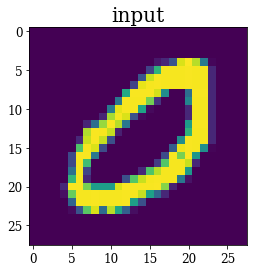

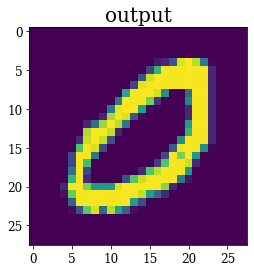

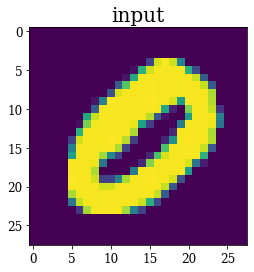

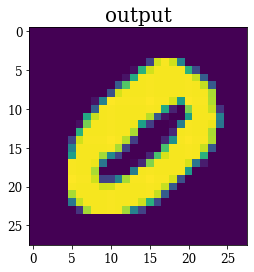

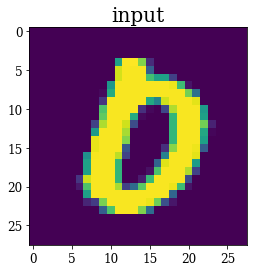

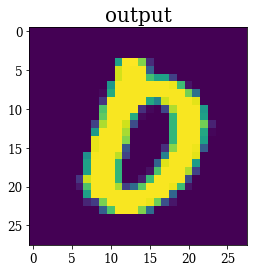

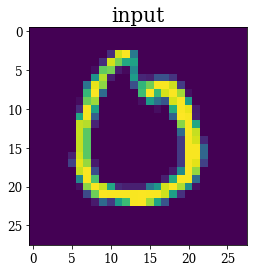

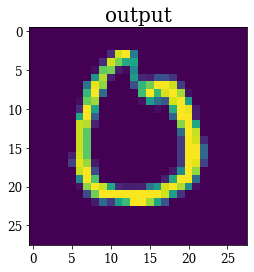

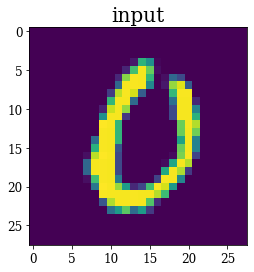

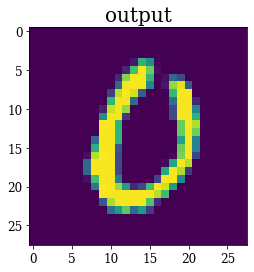

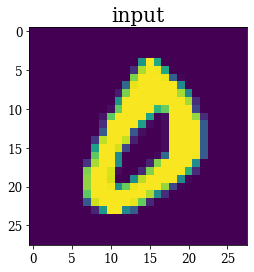

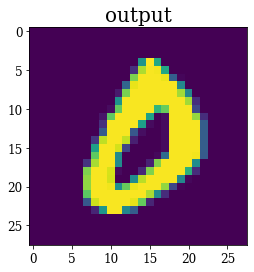

In [4]:
mnist_env_zeros = NoisyMnistEnv("test", 0, 1)
x, y  = mnist_env_zeros.step()
count = 0
for i in zip(x,y):
    count += 1
    if count == 16:
        break
    plt.title("input", fontsize=20)
    plt.imshow(np.squeeze(i[0]).reshape(28, 28))
    plt.show()
    plt.title("output", fontsize=20)
    plt.imshow(np.squeeze(i[1]).reshape(28, 28))
    plt.show()

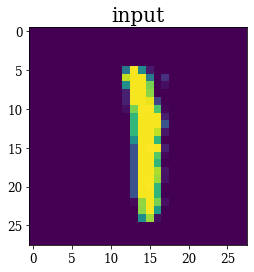

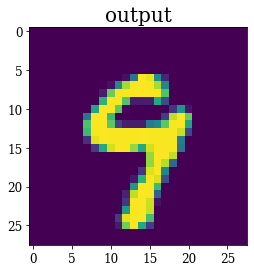

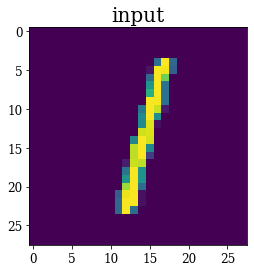

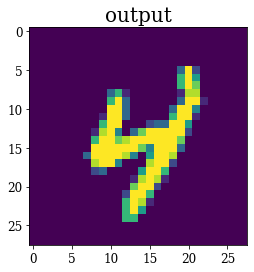

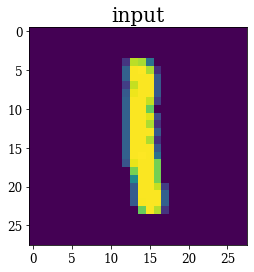

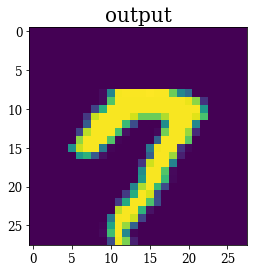

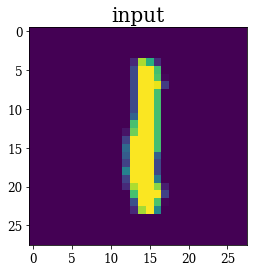

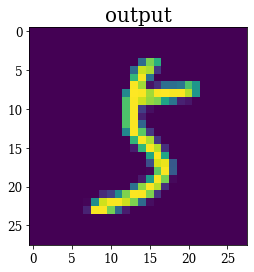

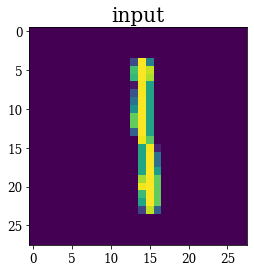

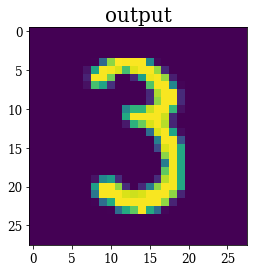

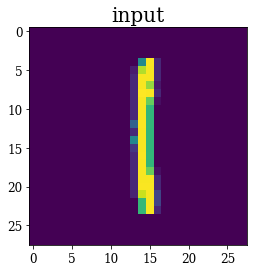

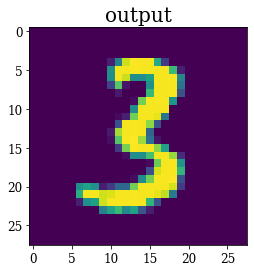

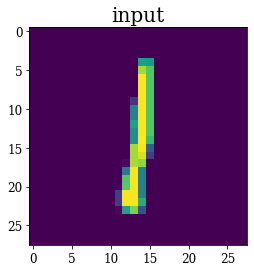

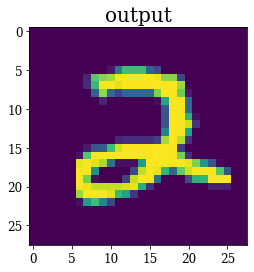

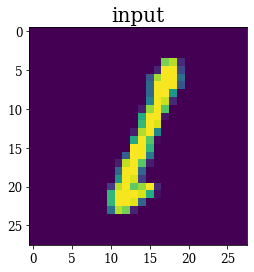

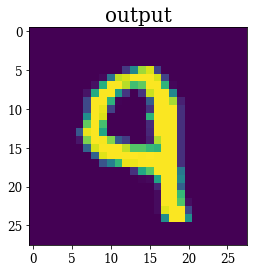

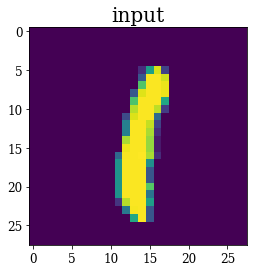

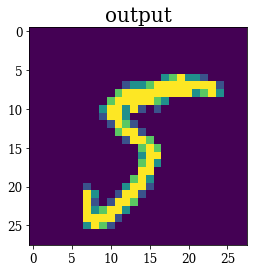

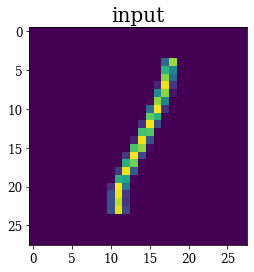

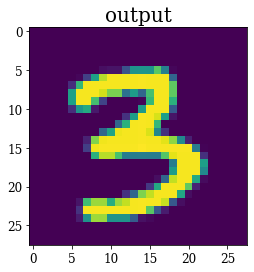

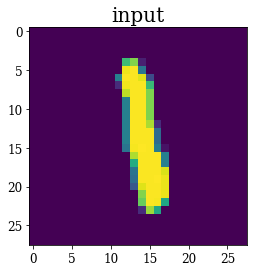

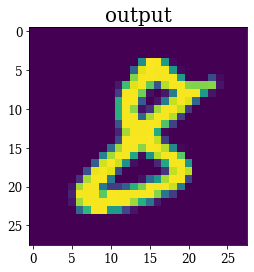

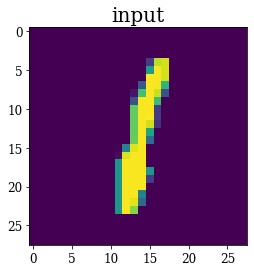

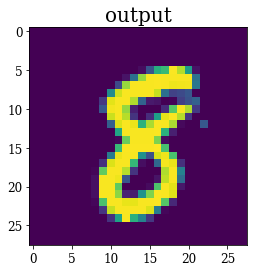

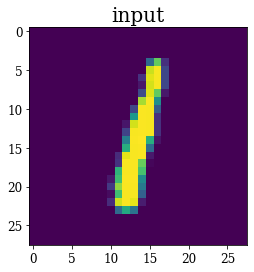

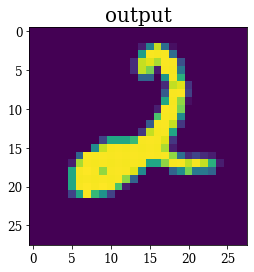

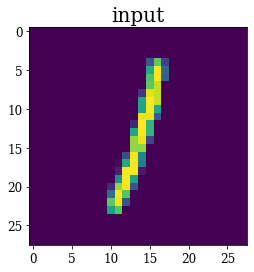

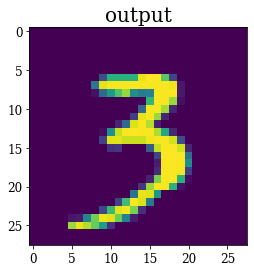

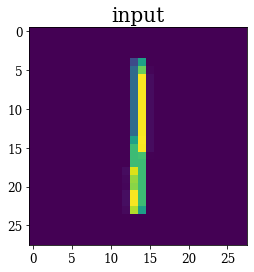

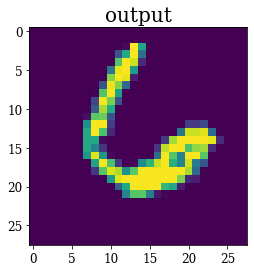

In [5]:
mnist_env_ones = NoisyMnistEnv("test", 1, 2)
x, y  = mnist_env_ones.step()
count = 0
for i in zip(x,y):
    count += 1
    if count == 16:
        break
    plt.title("input", fontsize=20)
    plt.imshow(np.squeeze(i[0]).reshape(28, 28))
    plt.show()
    plt.title("output", fontsize=20)
    plt.imshow(np.squeeze(i[1]).reshape(28, 28))
    plt.show()

## Defining Models ##

In [6]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

# from here https://github.com/L1aoXingyu/pytorch-beginner/tree/master/08-AutoEncoder
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_1 = nn.Linear(28 * 28, 128)
        self.linear_2 = nn.Linear(128, 128)
        self.linear_3 = nn.Linear(128, 128)
        self.linear_4 = nn.Linear(128, 28 * 28)
        
    def forward(self, x):
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))
        x = F.relu(self.linear_3(x))
        x = (self.linear_4(x))
        return x
    
# from here https://github.com/L1aoXingyu/pytorch-beginner/tree/master/08-AutoEncoder
class AleatoricNet(nn.Module):
    def __init__(self):
        super(AleatoricNet, self).__init__()
        self.linear_1 = nn.Linear(28 * 28, 128)
        self.linear_2 = nn.Linear(128, 128)
        self.linear_3_mu = nn.Linear(128, 128)
        self.linear_4_mu = nn.Linear(128, 28 * 28)
        self.linear_3_sigma = nn.Linear(128, 128)
        self.linear_4_sigma = nn.Linear(128, 28 * 28)
        
    def forward(self, x):
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))
        mu = F.relu(self.linear_3_mu(x))
        mu = (self.linear_4_mu(mu))
        log_sigma = F.relu(self.linear_3_sigma(x))
        log_sigma = (self.linear_4_sigma(log_sigma))
        return mu, log_sigma

# Defining MNIST Experiment

In [ ]:
class NoisyMNISTExperimentRun:
    def __init__(self, repeats, training_steps, checkpoint_loss, lr, model):
        self.training_steps = training_steps 
        self.checkpoint_loss = checkpoint_loss
        self.repeats = repeats
        self.model = model
        self.device = device
        self.lr = lr
        self.reset_model()
        
    def run_experiment(self):
        for repeat in self.repeats:
            self.reset_model()
            self.reset_loss_buffers()
            for update in tqdm(range(int(self.training_steps))):
                self.train_step(update)
                self.eval_step("ones", update)
                self.eval_step("zeros", update)
                
    def preprocess_batch(self, data, target):
        data /= 255
        target /= 255
        return data, target
    
    def compute_loss_and_reward(prediction, target):
        loss = F.mse_loss(prediction, target)
        reward = loss
        return loss, reward
        
    def get_batch(self, env):
        data, target = env.step()
        data, target = self.preprocess_batch(data, target)
        data = torch.from_numpy(data).float().to(device)
        target = torch.from_numpy(target).float().to(device)
        return data, target
    
    def train_step(self, update):
        data, target = self.get_batch(mnist_env)
        self.opt.zero_grad()
        output = self.model(data)
        loss, reward = self.compute_loss(output, target)
        loss.backward()
        self.opt.step()
        self.loss_buffer.append(reward)
        if update % self.checkpoint_loss == 0:
            self.loss_list.append(torch.mean(torch.stack(self.loss_buffer)).detach().cpu().numpy())
            self.loss_buffer = []
            
    def eval_step(self, ones_or_zeros, update):
        self.model_eval()
        assert ones_or_zero in ["ones", "zeros"]
        if ones_or_zero = "ones":
            env = mnist_env_ones
        elif ones_or_zero == "zeros":
            env = mnist_env_zeros 
        data, target = self.get_batch(env)
        output = self.model(data)
        loss, reward = self.compute_loss_and_reward(output, target)
        if ones_or_zero == "ones":
            self.loss_buffer_1.append(reward)
            if update % checkpoint_loss == 0:
                print(self.loss_buffer_1)
                print(torch.stack(self.loss_buffer_1))
                loss_list_1.append(torch.mean(torch.stack(self.loss_buffer_1)).detach().cpu().numpy())
                print("loss 0", torch.mean(torch.stack(self.loss_buffer_1)).detach().cpu().numpy())
                self.loss_buffer_1 = []
        elif ones_or_zero == "zeros":
            self.loss_buffer_0.append(reward)
            if update % checkpoint_loss == 0:
                print(self.loss_buffer_0)
                print(torch.stack(self.loss_buffer_0))
                self.loss_list_0.append(torch.mean(torch.stack(self.loss_buffer_0)).detach().cpu().numpy())
                print("loss 0", torch.mean(torch.stack(self.loss_buffer_0)).detach().cpu().numpy())
                self.loss_buffer_0 = []
        
    def reset_model(self):
        self.model = self.model.to(self.device)
        self.opt = optim.Adam(self.model.parameters(), lr=self.lr)
        
    def reset_loss_buffers(self):
        self.loss_list = []
        self.loss_buffer = []
        self.loss_list_0 = []
        self.loss_list_1 = []
        self.loss_buffer_0 = []
        self.loss_buffer_1 = []
        
class NoisyMNISTExperimentRunAMA(NoisyMNISTExperimentRun):
    def __init__(self, repeats, training_steps, checkpoint_loss, lr, model):
        NoisyMNISTExperimentRun.__init__(self, repeats, training_steps, checkpoint_loss, lr, model)
    
    def compute_loss_and_reward(self, prediction, target):
        mse = F.mse_loss(mu, target, reduction="none")
        loss = torch.mean(torch.exp(-log_sigma) * mse + log_sigma)
        reward = torch.mean(mse - torch.exp(log_sigma))
        return loss, reward

# Experiment Tests

### Vanilla Experiment ###

In [24]:
model = Net()
experiment = NoisyMNISTExperimentRun(repeats,training_steps,checkpoint_loss,lr,model)
experiment.run_experiment()




  0%|          | 0/10000 [00:00<?, ?it/s]


  0%|          | 6/10000 [00:00<02:56, 56.67it/s]


  0%|          | 12/10000 [00:00<02:53, 57.48it/s]

[tensor(0.1397, device='cuda:0', grad_fn=<MseLossBackward>)]
tensor([0.1397], device='cuda:0', grad_fn=<StackBackward>)
loss 0 0.13974224
loss 1 0.120586365





  0%|          | 18/10000 [00:00<02:52, 57.75it/s]


  0%|          | 24/10000 [00:00<02:53, 57.60it/s]


  0%|          | 30/10000 [00:00<02:51, 58.23it/s]


  0%|          | 36/10000 [00:00<02:51, 58.25it/s]


  0%|          | 42/10000 [00:00<02:50, 58.25it/s]


  0%|          | 48/10000 [00:00<02:50, 58.33it/s]


  1%|          | 54/10000 [00:00<02:49, 58.69it/s]


  1%|          | 60/10000 [00:01<02:49, 58.73it/s]


  1%|          | 66/10000 [00:01<02:48, 58.93it/s]


  1%|          | 72/10000 [00:01<02:48, 59.02it/s]


  1%|          | 79/10000 [00:01<02:46, 59.44it/s]


  1%|          | 85/10000 [00:01<02:46, 59.40it/s]


  1%|          | 92/10000 [00:01<02:46, 59.65it/s]


  1%|          | 98/10000 [00:01<02:47, 59.20it/s]


  1%|          | 104/10000 [00:01<02:47, 59.05it/s]


  1%|          | 110/10000 [00:01<02:47, 59.19it/s]


  1%|          | 116/10000 [00:01<02:47, 59.11it/s]


  1%|          | 122/10000 [00:02<02:46, 59.21it/s]


  1%|▏         | 128/10000 [00:02<02:46

[tensor(0.1350, device='cuda:0', grad_fn=<MseLossBackward>), tensor(0.1414, device='cuda:0', grad_fn=<MseLossBackward>), tensor(0.1431, device='cuda:0', grad_fn=<MseLossBackward>), tensor(0.1361, device='cuda:0', grad_fn=<MseLossBackward>), tensor(0.1398, device='cuda:0', grad_fn=<MseLossBackward>), tensor(0.1234, device='cuda:0', grad_fn=<MseLossBackward>), tensor(0.1239, device='cuda:0', grad_fn=<MseLossBackward>), tensor(0.1123, device='cuda:0', grad_fn=<MseLossBackward>), tensor(0.0963, device='cuda:0', grad_fn=<MseLossBackward>), tensor(0.0991, device='cuda:0', grad_fn=<MseLossBackward>), tensor(0.0959, device='cuda:0', grad_fn=<MseLossBackward>), tensor(0.0875, device='cuda:0', grad_fn=<MseLossBackward>), tensor(0.0823, device='cuda:0', grad_fn=<MseLossBackward>), tensor(0.0806, device='cuda:0', grad_fn=<MseLossBackward>), tensor(0.0771, device='cuda:0', grad_fn=<MseLossBackward>), tensor(0.0735, device='cuda:0', grad_fn=<MseLossBackward>), tensor(0.0690, device='cuda:0', grad_fn




 10%|█         | 1015/10000 [00:17<04:17, 34.92it/s]


 10%|█         | 1021/10000 [00:17<03:48, 39.30it/s]


 10%|█         | 1027/10000 [00:17<03:26, 43.46it/s]


 10%|█         | 1033/10000 [00:18<03:11, 46.79it/s]


 10%|█         | 1039/10000 [00:18<03:00, 49.75it/s]


 10%|█         | 1045/10000 [00:18<02:51, 52.17it/s]


 11%|█         | 1051/10000 [00:18<02:46, 53.84it/s]


 11%|█         | 1057/10000 [00:18<02:41, 55.32it/s]


 11%|█         | 1063/10000 [00:18<02:38, 56.32it/s]


 11%|█         | 1069/10000 [00:18<02:35, 57.35it/s]


 11%|█         | 1075/10000 [00:18<02:34, 57.64it/s]


 11%|█         | 1081/10000 [00:18<02:33, 58.20it/s]


 11%|█         | 1088/10000 [00:19<02:31, 58.94it/s]


 11%|█         | 1094/10000 [00:19<02:30, 59.19it/s]


 11%|█         | 1100/10000 [00:19<02:31, 58.90it/s]


 11%|█         | 1106/10000 [00:19<02:30, 59.13it/s]


 11%|█         | 1112/10000 [00:19<02:29, 59.27it/s]


 11%|█         | 1119/10000 [00:19<02:29, 59.52it/s]


 11%|█▏

KeyboardInterrupt: 

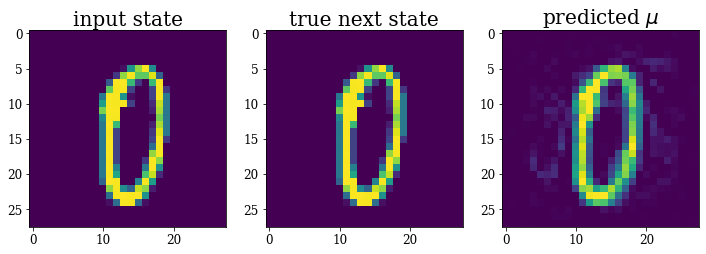

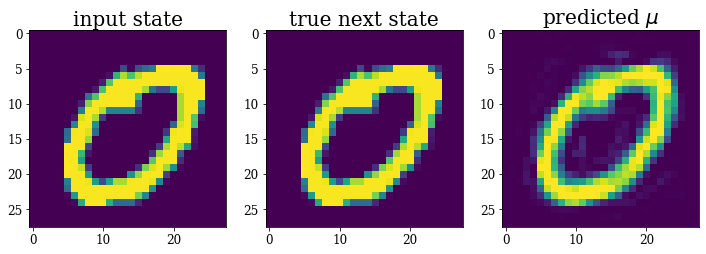

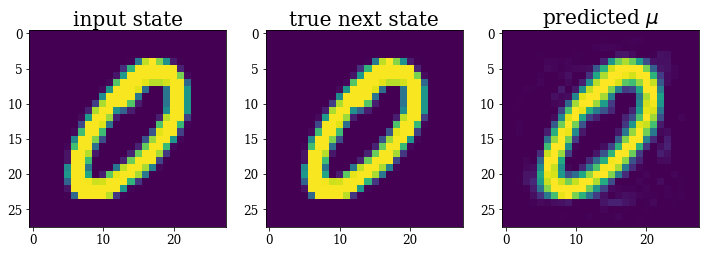

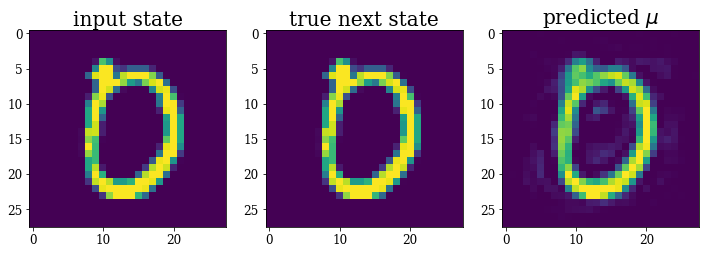

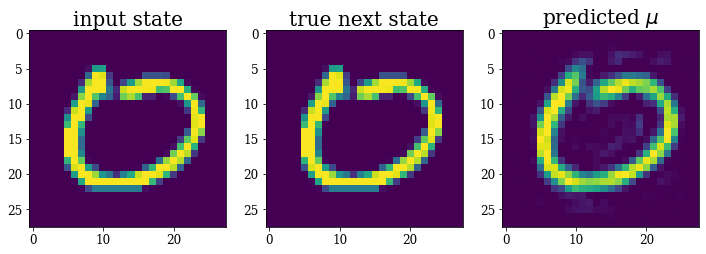

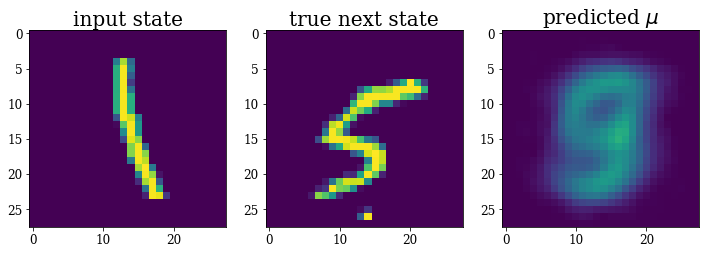

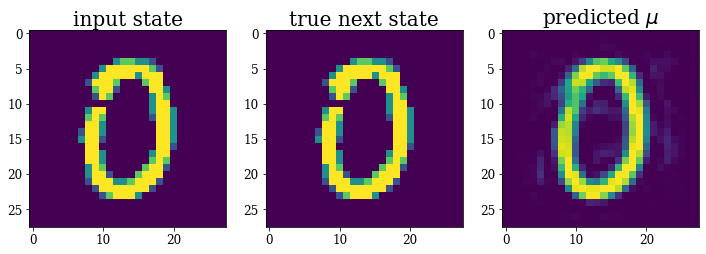

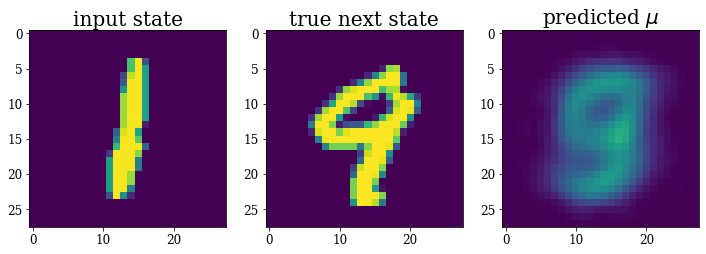

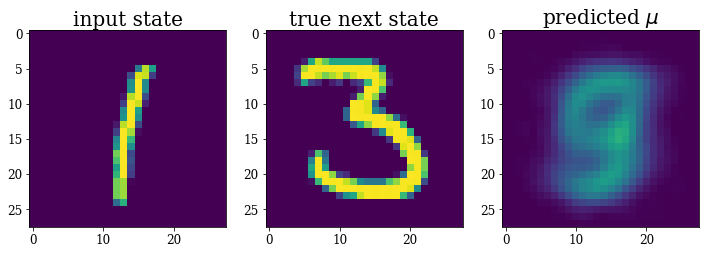

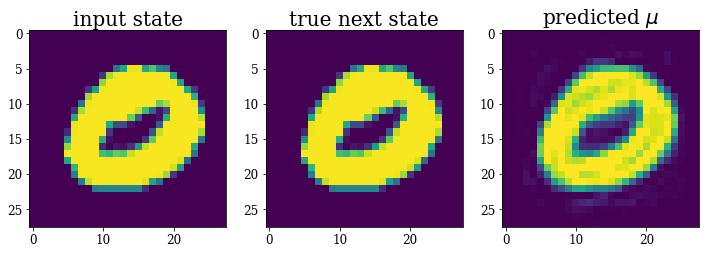

In [22]:
data_zeros, target_zeros = mnist_env_zeros.step()
data_ones, target_ones = mnist_env_ones.step()
data = np.concatenate((data_zeros, data_ones), axis=0)
target = np.concatenate((target_zeros, target_ones), axis=0)
data, target = unison_shuffled_copies(data, target)
predictions = model(torch.from_numpy(data).float().to(device)/255)

for i in range(10):
    w=10
    h=10
    fig=plt.figure(figsize=(12, 12))
    columns = 3
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(data[i].reshape(28, 28)/255, vmin=0, vmax=1)
    plt.title("input state", fontsize=20)

    fig.add_subplot(rows, columns, 2)
    plt.imshow(target[i].reshape(28, 28)/255, vmin=0, vmax=1)
    plt.title("true next state", fontsize=20)

    fig.add_subplot(rows, columns, 3)
    plt.imshow(predictions[i].detach().cpu().numpy().reshape(28, 28), vmin=0, vmax=1)
    plt.title("predicted $\mu$", fontsize=20)
    plt.show()
    
    #np.save("lost_list_deterministic_" + str(repeat) + ".npy", loss_list_0)
    #np.save("lost_list_stochastic_" + str(repeat) + ".npy", loss_list_1)

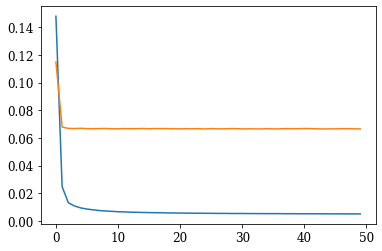

In [8]:
plt.plot(loss_list_0)
plt.plot(loss_list_1)

### Aleatoric Experiment ###

In [ ]:
model = AleatoricNet()
experiment = NoisyMNISTExperimentRunAMA(repeats,training_steps,checkpoint_loss,lr,model)
experiment.run_experiment()

In [ ]:
plt.plot(loss_list_0_aleatoric)
plt.plot(loss_list_1_aleatoric)
plt.ylim(-0.05,0.01)

<Figure size 16000x12000 with 0 Axes>

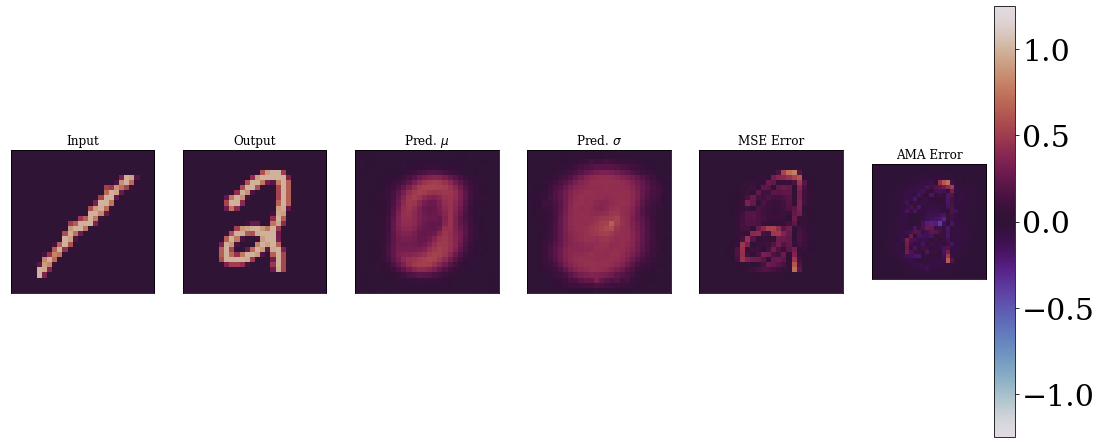

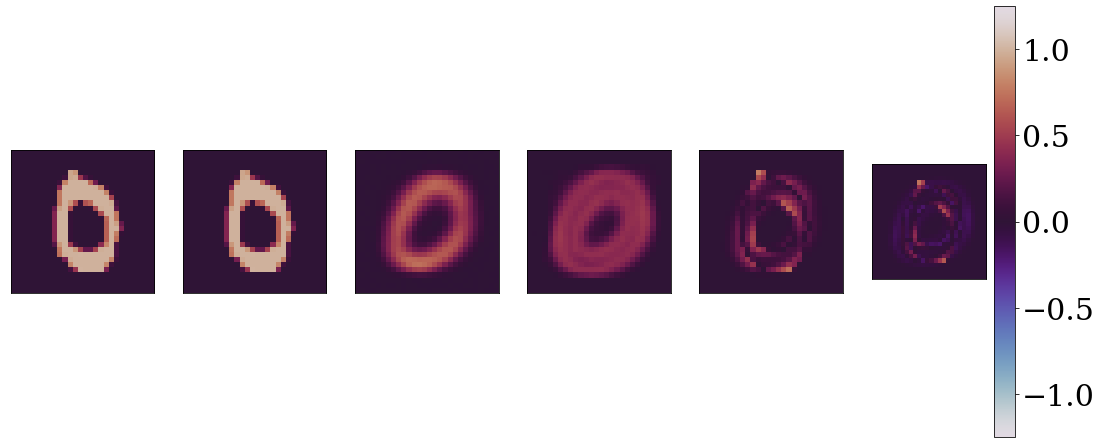

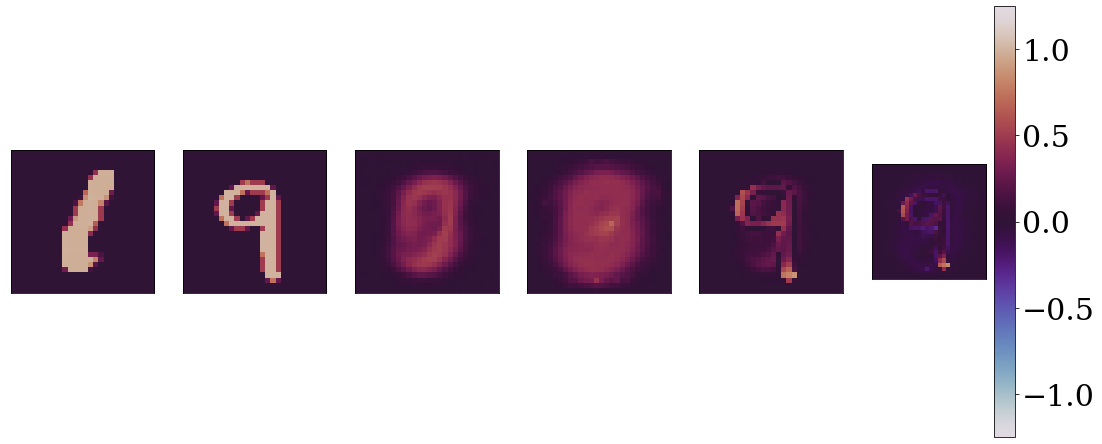

In [12]:
#https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


data_zeros, target_zeros = mnist_env_zeros.step()
data_ones, target_ones = mnist_env_ones.step()
data = np.concatenate((data_zeros, data_ones), axis=0)
target = np.concatenate((target_zeros, target_ones), axis=0)
data, target = unison_shuffled_copies(data, target)
mu, sigma = model(torch.from_numpy(data).float().to(device)/255)

from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=2000, facecolor='w', edgecolor='k')
title_size = 12
cmap='twilight'
lower_color, higher_color = -1.25, 1.25 

for i in range(3):
    
    w=10
    h=10
    fig=plt.figure(figsize=(18, 18))
    columns = 6
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(data[i].reshape(28, 28)/255, vmin=-1.2, vmax=1.2, cmap=cmap)
    plt.clim(lower_color,higher_color) 
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title(r"Input", fontsize=title_size)
    
    fig.add_subplot(rows, columns, 2)
    plt.imshow(target[i].reshape(28, 28)/255, vmin=-1.2, vmax=1.2, cmap=cmap)
    plt.clim(lower_color,higher_color) 
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title(r"Output", fontsize=title_size)
    
    fig.add_subplot(rows, columns, 3)
    plt.imshow(mu[i].detach().cpu().numpy().reshape(28, 28), vmin=-1.2, vmax=1.2, cmap=cmap)
    assert np.amin(mu[i].detach().cpu().numpy().reshape(28, 28)) > -1
    assert np.amax(mu[i].detach().cpu().numpy().reshape(28, 28)) < 1
    plt.clim(lower_color,higher_color) 
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title("Pred. $\mu$", fontsize=title_size)
    
    fig.add_subplot(rows, columns, 4)
    plt.imshow(np.sqrt(np.exp((sigma[i].detach().cpu().numpy().reshape(28, 28)))), vmin=-1.2, vmax=1.2, cmap=cmap)
    assert np.amin(np.sqrt(np.exp((sigma[i].detach().cpu().numpy().reshape(28, 28))))) > -1
    assert np.amax(np.sqrt(np.exp((sigma[i].detach().cpu().numpy().reshape(28, 28))))) < 1
    plt.clim(lower_color,higher_color) 
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title("Pred. $\sigma$", fontsize=title_size)
    
    fig.add_subplot(rows, columns, 5)
    error = ((mu[i].detach().cpu().numpy() - target[i]/255)**2).reshape(28, 28)
    avg_error = np.mean(error)
    plt.imshow(error, vmin=-1.2, vmax=1.2, cmap=cmap)
    assert np.amin(error) > -1
    assert np.amax(error) < 1
    plt.clim(lower_color,higher_color) 
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title("MSE Error", fontsize=title_size)

    fig.add_subplot(rows, columns, 6)
    error = ((mu[i].detach().cpu().numpy() - target[i]/255)**2).reshape(28,28) - np.exp(sigma[i].detach().cpu().numpy()).reshape(28, 28) 
    assert np.amax(((mu[i].detach().cpu().numpy() - target[i]/255)**2).reshape(28,28) - np.exp(sigma[i].detach().cpu().numpy()).reshape(28, 28)) < 1.0
    assert np.amin(((mu[i].detach().cpu().numpy() - target[i]/255)**2).reshape(28,28) - np.exp(sigma[i].detach().cpu().numpy()).reshape(28, 28)) > -1.0
    plt.imshow(error, vmin=-1.2, vmax=1.2, cmap=cmap)
    plt.clim(lower_color,higher_color) 
    avg_error = np.mean(error)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title("AMA Error", fontsize=title_size)
    #print(((mu[i].detach().cpu().numpy() - target[i]/255)**2).reshape(28,28) - np.exp(sigma[i].detach().cpu().numpy()).reshape(28, 28))
    #if i == 0:~}
    #cbar = plt.colorbar()
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(30)
    
    plt.show()

Text(0.5, 1.0, 'Noisy MNIST')

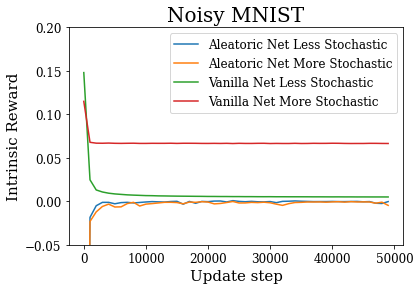

In [14]:
updates = [x * 1000 for x in list(range(len(loss_list_0_aleatoric)))]
plt.plot(updates,loss_list_0_aleatoric,label="Aleatoric Net Less Stochastic")
plt.plot(updates,loss_list_1_aleatoric,label="Aleatoric Net More Stochastic")
plt.plot(updates,loss_list_0,label="Vanilla Net Less Stochastic")
plt.plot(updates,loss_list_1,label="Vanilla Net More Stochastic")
plt.legend(loc="best", fontsize=12)
plt.ylabel("Intrinsic Reward", fontsize=15)
plt.xlabel("Update step", fontsize=15)
plt.ylim(-0.05, 0.2)
plt.title("Noisy MNIST", fontsize=20)

# Arxiv Plots

['lost_list_stochastic_0.npy', 'lost_list_stochastic_1.npy', 'lost_list_stochastic_4.npy', 'lost_list_stochastic_2.npy', 'lost_list_stochastic_3.npy']
['lost_list_deterministic_3.npy', 'lost_list_deterministic_2.npy', 'lost_list_deterministic_4.npy', 'lost_list_deterministic_1.npy', 'lost_list_deterministic_0.npy']
['lost_list_aleatoric_stochastic_2.npy', 'lost_list_aleatoric_stochastic_1.npy', 'lost_list_aleatoric_stochastic_3.npy', 'lost_list_aleatoric_stochastic_4.npy', 'lost_list_aleatoric_stochastic_0.npy']
['lost_list_aleatoric_deterministic_3.npy', 'lost_list_aleatoric_deterministic_0.npy', 'lost_list_aleatoric_deterministic_4.npy', 'lost_list_aleatoric_deterministic_1.npy', 'lost_list_aleatoric_deterministic_2.npy']


Text(0.5, 1.0, 'Noisy MNIST')

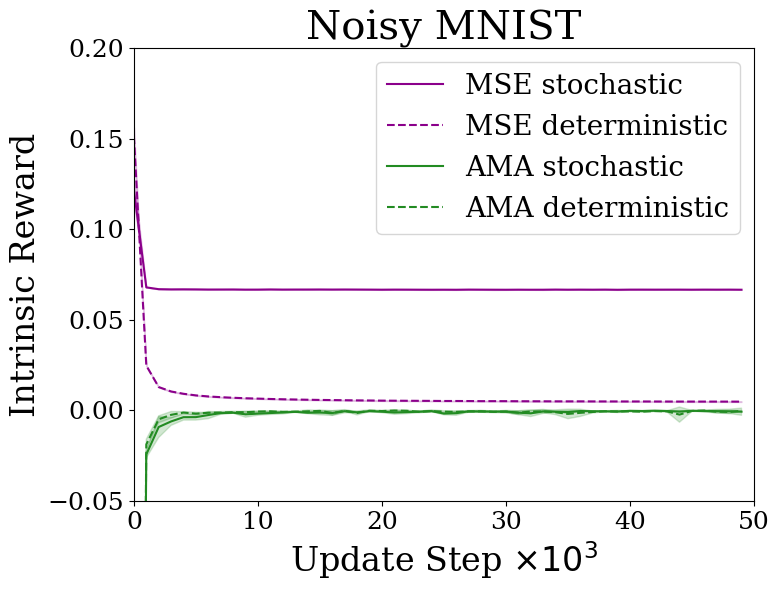

In [15]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
from matplotlib import rcParams
rcParams['axes.titlepad'] =2 

def load_files_into_arr(list_of_file_paths):
    all_arrs = []
    for a_file in list_of_file_paths:
        all_arrs.append(np.load(a_file))
    return all_arrs

def get_mean_and_std_dev(arr_of_results):
    return np.mean(arr_of_results, axis=0), np.std(arr_of_results, axis=0)

def plot_mean_and_std(mean, std, label):
    assert len(mean) == len(std)
    if "stochastic" in label:
        linestyle="-"
    else:
        linestyle="--"
    if "AMA" in label:
        color="forestgreen"
    else:
        color="darkmagenta"
    plt.plot(list(range(len(mean))), mean, linestyle=linestyle, label=label, color=color)
    x = list(range(len(mean)))
    plt.fill_between(x, (mean-std), (mean+std), alpha=0.2, color=color)

import glob
npy_files = glob.glob("*npy")
aleatoric_stochastic = [file for file in npy_files if "stochastic" in file and "aleatoric" in file]
aleatoric_deterministic = [file for file in npy_files if "deterministic" in file and "aleatoric" in file]
vanilla_deterministic = [file for file in npy_files if "aleatoric" not in file and "deterministic" in file]
vanilla_stochastic = [file for file in npy_files if "aleatoric" not in file and "stochastic" in file]

list_of_file_lists =[vanilla_stochastic, vanilla_deterministic, aleatoric_stochastic, aleatoric_deterministic,]

print(vanilla_stochastic)
print(vanilla_deterministic)
print(aleatoric_stochastic)
print(aleatoric_deterministic)

legends = [r"MSE stochastic",
           r"MSE deterministic",
           r"AMA stochastic",
           r"AMA deterministic"]

colors = ["darkmagenta", "forestgreen"]
plt.xlim(0, 50)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)

for i, files in enumerate(list_of_file_lists):
    results = load_files_into_arr(files)
    mu, sigma = get_mean_and_std_dev(results)
    plot_mean_and_std(mu, sigma, legends[i])

plt.rc('font', family='serif')
plt.legend(loc="best", fontsize=20)
plt.ylabel("Intrinsic Reward", fontsize=24)
plt.xlabel(r"Update Step $\times 10 ^{3}$", fontsize=24)
plt.ylim(-0.05, 0.2)
plt.title("Noisy MNIST", fontsize=29)